# ChemBERTa: Large-Scale Self-Supervised Pretraining for Molecular Property Prediction using a Smiles Tokenization Strategy

Based on ChemBERTa author Seyone Chithrananda's work

## Setup

This will take about 5 minutes to run to completion and install your environment.


In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e


In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

In [ ]:
from rdkit import Chem

We will be installing `simple-transformers`, a library which builds ontop of HuggingFace's `transformers` package specifically for fine-tuning ChemBERTa.

In [ ]:
!git clone https://github.com/NVIDIA/apex
!cd apex
!pip install -v --no-cache-dir apex
!pip install transformers
!pip install simpletransformers
!pip install wandb
!cd ..

In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

We're going to clone an auxillary repository, bert-loves-chemistry, which will enable us to use the MolNet dataloader for ChemBERTa, which automatically generates scaffold splits on any MoleculeNet dataset

In [ ]:
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

In [ ]:
!nvidia-smi

Now, to ensure our model demonstrates an understanding of chemical syntax and molecular structure, we'll be testing it on predicting a masked token/character within the SMILES molecule for benzene.

# Zero Shot Inference with chemBERTa

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer
from bertviz import head_view

# Load pre-trained models from hugging face
pytorchmodel = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_396_250", resume_download=True)
pytorchtokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_396_250")

# Create an inference pipeline
fill_mask = pipeline('fill-mask', model=pytorchmodel, tokenizer=pytorchtokenizer)

In [ ]:
smiles_mask = "C1=CC=CC<mask>C1"
smiles = "C1=CC=CC=C1"

# Make prediction of the masked symbol
masked_smi = fill_mask(smiles_mask)

for smi in masked_smi:
  print(smi)

Here, we get some interesting results. The final branch, `C1=CC=CC=C1`, is a  benzene ring. Since its a pretty common molecule, the model is easily able to predict the final double carbon bond with a score of 0.98. Let's get a list of the top 5 predictions (including the target, Remdesivir), and visualize them (with a highlighted focus on the beginning of the final benzene-like pattern).


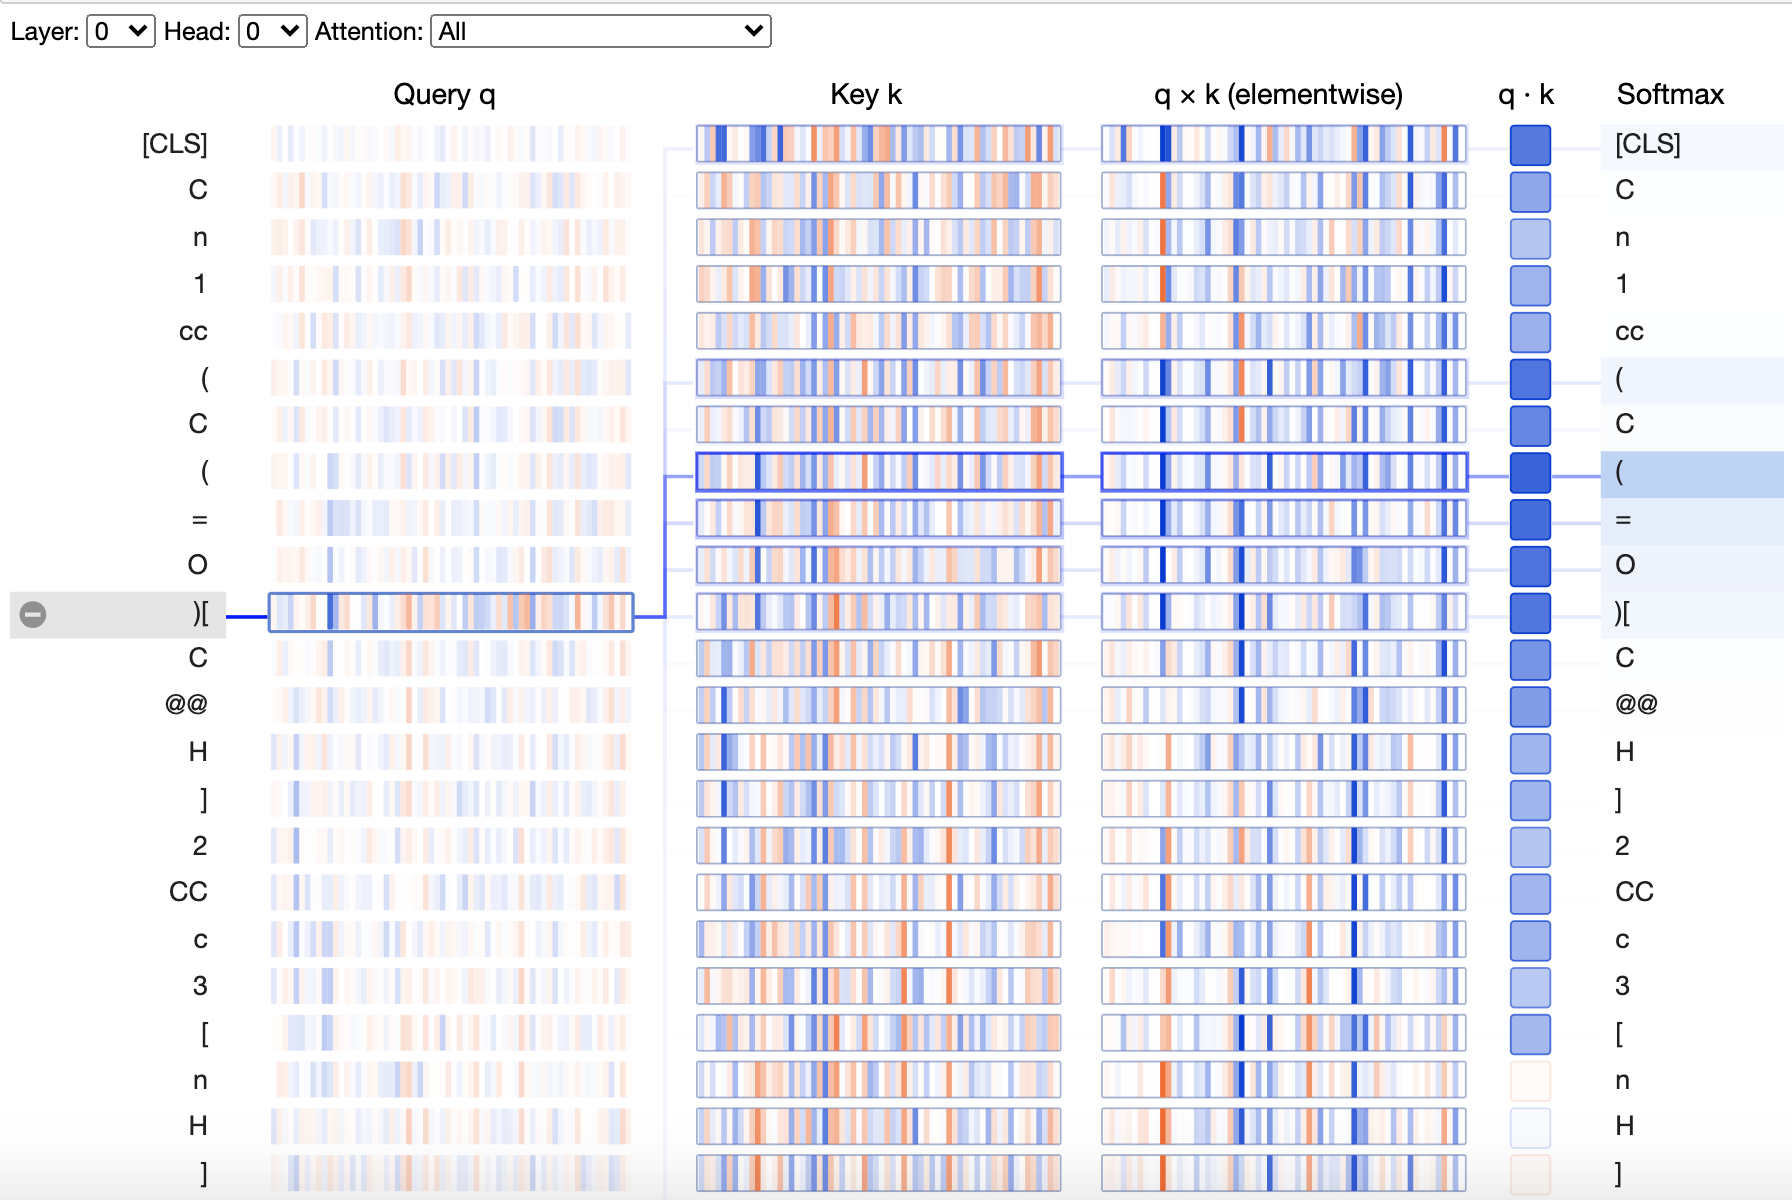

You can try out the ChemBERTa attention visualization demo's in more detail, with custom SMILES/SELFIES strings, tokenizers, and more in the public library, [here](https://github.com/seyonechithrananda/bert-loves-chemistry).

# Transfer Learning with ChemBERTa

Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

By pre-training directly on SMILES strings, and teaching ChemBERTa to recognize masked tokens in each string, the model learns a strong molecular representation. We then can take this model, trained on a structural chemistry task, and apply it to a suite of classification tasks in the MoleculeNet suite.



# Fine-tuning ChemBERTa on a Small Mollecular Dataset

Our fine-tuning dataset, ClinTox, consists of qualitative data of drugs approved by the FDA and those that have failed clinical trials for toxicity reasons.

The ClinTox dataset consists of 1478 binary labels for toxicity, using the SMILES representations for identifying molecules. The computational models produced from the dataset could become decision-making tools for government agencies in determining which drugs are of the greatest potential concern to human health. Additionally, these models can act as drug screening tools in the drug discovery pipelines for toxicity.

Let's start by importing the MolNet dataloder from `bert-loves-chemistry`, the tool which will allow us to import the ChemBERTA language model (LM) trained on PubChem-10M.

In [ ]:
%cd bert-loves-chemistry

In [ ]:
!pwd

In [ ]:
import os

import numpy as np
import pandas as pd

from typing import List

# import molnet loaders from deepchem
from deepchem.molnet import load_bbbp, load_clearance, load_clintox, load_delaney, load_hiv, load_qm7, load_tox21
from rdkit import Chem


# import MolNet dataloder from bert-loves-chemistry fork
from chemberta.utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop


We will be comparing the BPE tokenization algorithm with a **custom SmilesTokenizer** based on a regex pattern, which we have released as part of DeepChem. To compare tokenizers, we pretrained an identical model tokenized using this novel tokenizer, on the PubChem-1M set. The pretrained model was evaluated on the BBBP and Tox21 in the paper. We found that the SmilesTokenizer narrowly outperformed the BPE algorithm by ∆PRC-AUC = $+0.021$. 

Though this result suggests that a more semantically relevant tokenization may provide performance benefits, further benchmarking on additional datasets is needed to validate this finding. we aim to do so in this section, by testing this alternate model on the ClinTox dataset.

Let's fetch the Smiles Tokenizer's character per line vocabulary file, which can be loaded from the DeepChem S3 data bucket:

In [ ]:
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt

Lets use the MolNet dataloader to generate scaffold splits from the ClinTox dataset.

In [ ]:
tasks, (train_df, valid_df, test_df), transformers = load_molnet_dataset("clintox", tasks_wanted=None)

Check training, validation, and test datasets

In [ ]:
train_df

In [ ]:
valid_df

In [ ]:
test_df

From here, lets set up a logger to record if any issues occur, and notify us if there are any problems with the arguments we've set for the model. 

In [ ]:
from simpletransformers.classification import ClassificationModel
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Now, using `simple-transformer`, let's load the pre-trained model from HuggingFace's useful model-hub. We'll set the number of epochs to 10 in the arguments, but you can train for longer, and pass early-stopping as an argument to prevent overfitting. Also make sure that `auto_weights` is set to True to do automatic weight balancing, as we are dealing with imbalanced toxicity datasets. 

ChemBERTa employs a bidirectional training context to learn context-aware representations of the PubChem 10M dataset. ChemBERTa, a variant of the BERT transformer uses 12 attention heads and 6 layers, resulting in 72 distinct attention mechanisms.

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

# Load pre-trained model
model = ClassificationModel('roberta', 'seyonec/PubChem10M_SMILES_BPE_396_250', use_cuda=True, args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 10, 'auto_weights': True}) # You can set class weights by using the optional weight argument

In [ ]:
# Check tokenier
print(model.tokenizer)

In [ ]:
# check if our train and evaluation dataframes are setup properly. There should only be two columns for the SMILES string and its corresponding label.
print("Train Dataset: {}".format(train_df.shape))
print("Eval Dataset: {}".format(valid_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

Now that we've set everything up, lets get to the fun part: training the model! We use Weights and Biases, which is optional (simply remove `wandb_project` from the list of `args`). Its a really useful tool for monitering the model's training results (such as accuracy, learning rate and loss), alongside custom visualizations of attention and gradients. 

When you run this cell, Weights and Biases will ask for an account, which you can setup through a Github account, giving you an authorization API key which you can paste into the output of the cell. Again, this is completely optional and it can be removed from the list of arguments.

In [ ]:
!wandb login <'your API key'>

Finally, the moment we've been waiting for! Let's train the model on the train scaffold set of ClinTox, and monitor our runs using W&B. We will evaluate the performance of our model each epoch using the validation set.

In [ ]:
train_df_limited = train_df.head(30)
valid_df_limited = valid_df.head(30)
test_df_limited = test_df.head(30)

In [ ]:
# Create directory to store model weights
!mkdir BPE_PubChem_10M_ClinTox_run

# Train the model, replace 'finetune_chemBERTa' with your project name in weights and biases
model.train_model(train_df_limited, eval_df=valid_df_limited, output_dir='/notebooks/BPE_PubChem_10M_ClinTox_run', args={'wandb_project': 'finetune_chemBERTa'})

Let's install scikit-learn now, to evaluate the model we've trained. We will be using the accuracy and PRC-AUC metrics (average precision score).

In [ ]:
import sklearn

# accuracy
result, model_outputs, wrong_predictions = model.eval_model(test_df_limited, acc=sklearn.metrics.accuracy_score)

# ROC-PRC
result, model_outputs, wrong_predictions = model.eval_model(test_df_limited, acc=sklearn.metrics.average_precision_score)

The model performs pretty well, averaging above 97% ROC-PRC after training on only ~1400 data samples and 150 positive leads in a couple of minutes! We can clearly see the predictive power of transfer learning, and approaches like these are becoming increasing popular in the pharmaceutical industry where larger datasets are scarce. By training on more epochs and tasks, we can probably boost the accuracy as well.

Lets evaluate the model on one last string from ClinTox's test set for toxicity. The model should predict 1, meaning the drug failed clinical trials for toxicity reasons and wasn't approved by the FDA.

In [ ]:
# Lets input a molecule with a toxicity value of 1
predictions, raw_outputs = model.predict(['C1=C(C(=O)NC(=O)N1)F'])

In [ ]:
print(predictions)
print(raw_outputs)

The model predicts the sample correctly! Some future tasks may include using the same model on multiple tasks (Tox21 provides multiple tasks relating to different biochemical pathways for toxicity, as an example), through multi-task classification, as well as training on a larger dataset such as HIV, one of the other harder tasks in molecular machine learning. This will be expanded on in future work! 

# Benchmarking Smiles-Tokenizer ChemBERTa models on ClinTox

Now lets compare how this model performs to a similar variant of ChemBERTa, that utilizes a different tokenizer, the [SmilesTokenizer](https://deepchem.readthedocs.io/en/latest/api_reference/tokenizers.html) which is built-in to DeepChem! Let see if using a tokenizer which splits SMILES sequences into syntatically relevant chemical tokens performs differently, especially on molecular property prediction.

First off, lets initialize this variant model:

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

model = ClassificationModel('roberta', 'seyonec/SMILES_tokenized_PubChem_shard00_160k', use_cuda=True, args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 10, 'auto_weights': True}) # You can set class weights by using the optional weight argument

In [ ]:
# check SMILES Tokenizer
print(model.tokenizer)

In [ ]:
# check if our train and evaluation dataframes are setup properly. There should only be two columns for the SMILES string and its corresponding label.
print("Train Dataset: {}".format(train_df.shape))
print("Eval Dataset: {}".format(valid_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

In [ ]:
!wandb login

In [ ]:
train_df_limited_smiles = train_df.head(30)
valid_df_limited_smiles = valid_df.head(30)
test_df_limited_smiles = test_df.head(30)

In [ ]:
# Create directory to store model weights (change path accordingly to where you want!)
!mkdir SmilesTokenizer_PubChem_10M_ClinTox_run

# Train the model
model.train_model(train_df_limited_smiles, eval_df=valid_df_limited_smiles, output_dir='/notebooks/SmilesTokenizer_PubChem_10M_ClinTox_run/benchmark', args={'wandb_project': 'chemBERTa_Finetune'})

In [ ]:
import sklearn

# accuracy
result, model_outputs, wrong_predictions = model.eval_model(test_df_limited, acc=sklearn.metrics.accuracy_score)

# ROC-PRC
result, model_outputs, wrong_predictions = model.eval_model(test_df_limited, acc=sklearn.metrics.average_precision_score)

The model performs incredibly well, averaging above 96% PRC-AUC after training on only ~1400 data samples and 150 positive leads in a couple of minutes! This model was also trained on 1/10th the amount of pre-training data as the PubChem-10M BPE model we used previously, but it still showcases robust performance. We can clearly see the predictive power of transfer learning, and approaches like these are becoming increasing popular in the pharmaceutical industry where larger datasets are scarce. By training on more epochs and tasks, we can probably boost the accuracy as well!

Lets evaluate the model on one last string from ClinTox's test set for toxicity. The model should predict 1, meaning the drug failed clinical trials for toxicity reasons and wasn't approved by the FDA.

In [ ]:
# Lets input a molecule with a toxicity value of 1
predictions, raw_outputs = model.predict(['C1=C(C(=O)NC(=O)N1)F'])

In [ ]:
print(predictions)
print(raw_outputs)

The model predicts the sample correctly. Some future tasks may include using the same model on multiple tasks (Tox21 provides multiple tasks relating to different biochemical pathways for toxicity, as an example), through multi-task classification, as well as training on a larger dataset such as HIV, one of the other harder tasks in molecular machine learning.

# Save the model

In [ ]:
# Save the model artifacts 
model.model.save_pretrained('chemBERTA_SMILES')
model.tokenizer.save_pretrained('chemBERTA_SMILES')
model.config.save_pretrained('chemBERTA_SMILES')

In [ ]:
# Install Snowpark
!pip install snowflake-snowpark-python[pandas]
!pip install snowflake-ml-python

In [ ]:
from snowflake.snowpark.session import Session

# Get account credentials from a json file
with open("snowflake_creds.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]
    database = data["database"]
    schema = data["schema"]
    warehouse = data["warehouse"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "warehouse": warehouse,
    "database": database,
    "schema": schema,
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [ ]:
# put model files in an internal stage called model
session.sql("""PUT file:///notebooks/bert-loves-chemistry/chemBERTA_SMILES/model.safetensor
@MODEL/chemBERTa AUTO_COMPRESS=FALSE OVERWRITE=TRUE;""").collect()

# Reload the model

In [ ]:
loaded_model = ClassificationModel('roberta', 'chemBERTA_SMILES', use_cuda = True)